# Imports

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
!pip install -r requirements.txt

<IPython.core.display.Javascript object>

In [3]:
import time
import asyncio
import concurrent.futures
import random
import os
from functools import partial
import json

import pandas as pd
import datasets
import matplotlib.pyplot as plt

from boto3.session import Session
from botocore.exceptions import ClientError
from anthropic_bedrock import AnthropicBedrock

<IPython.core.display.Javascript object>

In [4]:
client = AnthropicBedrock()

<IPython.core.display.Javascript object>

In [5]:
os.environ["OPENAI_API_KEY"] = (
   <OPEN-AI_API-KEY>
)

<IPython.core.display.Javascript object>

## Mixture of Agents Setup

In this scenario, we will be employing a two-layered Mixture of Experts (MoE) architecture. The initial two layers comprise proposers, each consisting of three Large Language Models (LLMs). These LLMs have the capability to operate with varying inference parameters, enabling them to propose a diverse range of responses.

![architecture](architecture-simple.png)

In [6]:
reference_models = [
    {
        "modelId": "anthropic.claude-3-haiku-20240307-v1:0",
        "inference_params": {"temperature": 0.5, "topP": 1.0, "top_k": 250},
        "maxTokens": 512,
    },
    {
        "modelId": "mistral.mixtral-8x7b-instruct-v0:1",
        "inference_params": {"temperature": 0.7, "topP": 1.0},
        "maxTokens": 512,
    },
    {
        "modelId": "us.meta.llama3-2-3b-instruct-v1:0",
        "inference_params": {"temperature": 0.5, "topP": 0.9},
        "maxTokens": 512,
    },
]

aggregator_model = {
    "modelId": "anthropic.claude-3-haiku-20240307-v1:0",
    "inference_params": {"temperature": 0.0, "topP": 1.0, "top_k": 250},
    "maxTokens": 512,
}

aggreagator_system_prompt = """You have been provided with a set of responses from various open-source models to the latest user query. Your task is to synthesize these responses into a single, high-quality response. It is crucial to critically evaluate the information provided in these responses, recognizing that some of it may be biased or incorrect. Your response should not simply replicate the given answers but should offer a refined, accurate, and comprehensive reply to the instruction. Ensure your response is well-structured, coherent, and adheres to the highest standards of accuracy and reliability. Do not write in response that this was synthesised from previous responses

Responses from models:"""

layers = 3

<IPython.core.display.Javascript object>

## Utils

In [7]:
def getFinalSystemPrompt(system_prompt, results):
    """Construct a system prompt for layers 2+ that includes the previous responses to synthesize."""
    for i, element in enumerate(results):
        if len(element[0]) == 0:
            return None
    return (
        system_prompt
        + "\n"
        + "\n".join(
            [
                f"<Response_{i+1}> {str(element[0])} </Response_{i+1}> \n\n"
                for i, element in enumerate(results)
            ]
        )
    )

<IPython.core.display.Javascript object>

In [8]:
print(
    getFinalSystemPrompt(
        system_prompt=aggreagator_system_prompt,
        results=[
            (
                "Here are 3 fun things to do in San Francisco:\n\n1. Visit the Golden Gate Bridge - This iconic landmark offers stunning views of the city and the bay. You can walk or bike across the bridge for an up-close experience.\n\n2. Explore Fisherman's Wharf - This lively waterfront area is home to seafood restaurants, street performers, the Musée Mécanique arcade, and Pier 39 with its sea lion colony.\n\n3. Ride the Cable Cars - San Francisco's historic cable cars are a fun and unique way to get around the hilly city. You can ride the cable cars up and down the steep streets.\n\nSome other popular activities in San Francisco include visiting the colorful murals of the Mission District, touring Alcatraz Island, checking out the views from Twin Peaks, and exploring the shops and restaurants in neighborhoods like North Beach and the Castro. There are lots of fun and unique experiences to be had in this vibrant city.",
                22,
                214,
            ),
            (
                " Sure, I'd be happy to help! San Francisco is a city with no shortage of fun activities. Here are three fun things you might consider doing:\n\n1. Visit the Exploratorium: The Exploratorium is a hands-on science museum located on the Embarcadero. It features over 650 interactive exhibits that cover a wide range of topics, from physics and biology to art and psychology. You can play with optical illusions, create your own mini-tornado, or explore the world of microbes. It's a great place to learn and have fun at the same time.\n2. Take a Ferry to Sausalito: Sausalito is a charming town located across the bay from San Francisco. You can take a ferry from the Ferry Building or Pier 39 and enjoy the scenic views of the Bay and the Golden Gate Bridge. Once you arrive in Sausalito, you can explore the town's many art galleries, boutiques, and restaurants. You can also rent a bike and ride along the waterfront.\n3. Visit the California Academy of Sciences: The California Academy of Sciences is a natural history museum located in Golden Gate Park. It features an aquarium, a planetarium, a rainforest dome, and a natural history museum. You can learn about the diverse ecosystems of California, see penguins and other marine life, and take a journey through the stars in the planetarium. It's a great place to spend a day exploring and learning about the natural world.\n\nI hope these suggestions are helpful and that you have a great time in San Francisco!",
                30,
                353,
            ),
            (
                "San Francisco is a vibrant city with endless options for entertainment and exploration. Here are 3 fun things to do in SF:\n\n1. **Explore Fisherman's Wharf and Pier 39**: This iconic waterfront district is known for its stunning views of the Golden Gate Bridge, sea lions at Pier 39, and a variety of seafood restaurants. You can also take a stroll along the pier, visit the Aquarium of the Bay, or ride the historic cable cars.\n\n2. **Take a stroll across the Golden Gate Bridge**: This iconic suspension bridge is a must-visit attraction in SF. You can walk, bike, or drive across the bridge for breathtaking views of the San Francisco Bay, Alcatraz Island, and the city skyline. If you're feeling adventurous, you can even take a guided tour or bike ride across the bridge.\n\n3. **Visit Alcatraz Island**: Once a notorious maximum-security prison, Alcatraz Island is now a popular tourist attraction. Take a ferry to the island and explore the former prison cells, listen to a guided audio tour, or take a self-guided tour of the island. You can also see the famous \"Cell Block C\" and learn about the island's infamous history.\n\nThese are just a few of the many fun things to do in SF. Whether you're interested in history, nature, or entertainment, there's something for everyone in this vibrant city!",
                49,
                284,
            ),
        ],
    )
)

You have been provided with a set of responses from various open-source models to the latest user query. Your task is to synthesize these responses into a single, high-quality response. It is crucial to critically evaluate the information provided in these responses, recognizing that some of it may be biased or incorrect. Your response should not simply replicate the given answers but should offer a refined, accurate, and comprehensive reply to the instruction. Ensure your response is well-structured, coherent, and adheres to the highest standards of accuracy and reliability. Do not write in response that this was synthesised from previous responses

Responses from models:
<Response_1> Here are 3 fun things to do in San Francisco:

1. Visit the Golden Gate Bridge - This iconic landmark offers stunning views of the city and the bay. You can walk or bike across the bridge for an up-close experience.

2. Explore Fisherman's Wharf - This lively waterfront area is home to seafood restaurant

<IPython.core.display.Javascript object>

In [9]:
def backoff_mechanism(
    func, modelId, inference_params, maxTokens, messages, prev_response, debug=True
):
    MAX_RETRIES = 5  # Maximum number of retries
    INITIAL_DELAY = 1  # Initial delay in seconds
    MAX_DELAY = 60  # Maximum delay in second

    delay = INITIAL_DELAY
    retries = 0

    while retries < MAX_RETRIES:
        try:
            return func(
                modelId=modelId,
                inference_params=inference_params,
                maxTokens=maxTokens,
                messages=messages,
                prev_response=prev_response,
                debug=debug,
            )
        except ClientError as exception_obj:
            if exception_obj.response["Error"]["Code"] == "ThrottlingException":
                print(f"Retry {retries + 1}/{MAX_RETRIES}")
                time.sleep(delay + random.uniform(0, 1))  # Add a random jitter
                delay = min(delay * 2, MAX_DELAY)
                retries += 1
            else:
                raise
    else:
        print("Max retries reached!")
        return "", 0, 0

<IPython.core.display.Javascript object>

In [10]:
def invoke_model(
    modelId, inference_params, maxTokens, messages, prev_response, debug=True
):
    bedrock = Session().client(
        service_name="bedrock-runtime",
    )

    if debug:
        print(f"Invoking {modelId}")

    system_prompt = (
        getFinalSystemPrompt(aggreagator_system_prompt, prev_response)
        if prev_response
        else []
    )

    if system_prompt is None:
        return "", 0, 0

    respone = None
    if modelId in (
        "mistral.mistral-7b-instruct-v0:2",
        "mistral.mixtral-8x7b-instruct-v0:1",
    ):

        if prev_response:
            messages[0]["content"][0][
                "text"
            ] = f"<s>[INST] {system_prompt} \n\n {messages[0]['content'][0]['text']} [/INST]"
        else:
            messages[0]["content"][0][
                "text"
            ] = f"<s>[INST] {messages[0]['content'][0]['text']} [/INST]"

        response = bedrock.converse(
            modelId=modelId,
            messages=messages,
            inferenceConfig={
                "maxTokens": maxTokens,
                "temperature": inference_params["temperature"],
                "topP": inference_params["topP"],
            },
            additionalModelRequestFields={
                f"{key}": inference_params[key]
                for key in inference_params.keys()
                if key not in ("temperature", "topP")
            },
        )
    else:

        response = bedrock.converse(
            modelId=modelId,
            messages=messages,
            system=([{"text": system_prompt}] if prev_response else []),
            inferenceConfig={
                "maxTokens": maxTokens,
                "temperature": inference_params["temperature"],
                "topP": inference_params["topP"],
            },
            additionalModelRequestFields={
                f"{key}": inference_params[key]
                for key in inference_params.keys()
                if key not in ("temperature", "topP")
            },
        )

    return (
        response["output"]["message"]["content"][0]["text"],
        response["usage"]["inputTokens"],
        response["usage"]["outputTokens"],
    )

<IPython.core.display.Javascript object>

In [11]:
prompt = "Hi, Sonnet"
messages = [{"role": "user", "content": [{"text": f"User Query: {prompt}"}]}]
backoff_mechanism(
    func=invoke_model,
    modelId="anthropic.claude-3-sonnet-20240229-v1:0",
    inference_params={"temperature": 0.5, "topP": 1.0, "top_k": 250},
    maxTokens=512,
    prev_response="",
    messages=messages,
)

Invoking anthropic.claude-3-sonnet-20240229-v1:0


('Hello! I\'m Claude, an AI assistant created by Anthropic. I don\'t actually have a name like "Sonnet." How can I help you today?',
 15,
 38)

<IPython.core.display.Javascript object>

In [12]:
async def run_llms(
    modelId, inference_params, maxTokens, messages, prev_response=None, debug=True
):
    """Runs a parrallel LLM call to multiple models while accounting for previous responses + rate limits."""
    return await asyncio.to_thread(
        backoff_mechanism,
        invoke_model,
        modelId,
        inference_params,
        maxTokens,
        messages,
        prev_response,
        debug,
    )

<IPython.core.display.Javascript object>

In [13]:
await run_llms(
    modelId="anthropic.claude-3-sonnet-20240229-v1:0",
    inference_params={"temperature": 0.5, "topP": 1.0, "top_k": 250},
    maxTokens=512,
    prev_response="",
    messages=messages,
)

Invoking anthropic.claude-3-sonnet-20240229-v1:0


('Hello! I\'m Claude, an AI assistant created by Anthropic. I don\'t have a specific name like "Sonnet", but I\'m happy to chat with you. How can I help you today?',
 15,
 47)

<IPython.core.display.Javascript object>

## Mixture of Agents - Usage

In [14]:
async def main():
    """Run the main loop of the MOA process."""
    user_prompt = "What are 3 fun things to do in SF?"

    messages = [{"role": "user", "content": [{"text": f"User Query: {user_prompt}"}]}]

    input_token_usage = 0
    output_token_usage = 0

    # Invoke Layer-1 of MoA
    results = await asyncio.gather(
        *[
            run_llms(
                modelId=reference_model["modelId"],
                inference_params=reference_model["inference_params"],
                maxTokens=reference_model["maxTokens"],
                messages=messages,
                prev_response=None,
            )
            for reference_model in reference_models
        ]
    )

    input_token_usage += sum([element[1] for element in results])
    output_token_usage += sum([element[2] for element in results])
    # Invoke Layer-2, Layer-3, .... Layer-(N-1) of MoA
    for _ in range(1, layers - 1):
        results = await asyncio.gather(
            *[
                run_llms(
                    modelId=reference_model["modelId"],
                    inference_params=reference_model["inference_params"],
                    maxTokens=reference_model["maxTokens"],
                    messages=messages,
                    prev_response=results,
                )
                for reference_model in reference_models
            ]
        )
        input_token_usage += sum([element[1] for element in results])
        output_token_usage += sum([element[2] for element in results])

    bedrock = Session().client(
        service_name="bedrock-runtime",
    )

    # Invoke the Aggregator model
    response = backoff_mechanism(
        func=invoke_model,
        modelId=aggregator_model["modelId"],
        inference_params=aggregator_model["inference_params"],
        maxTokens=aggregator_model["maxTokens"],
        messages=messages,
        prev_response=results,
    )

    input_token_usage += response[1]
    output_token_usage += response[2]

    print(f"Final Response:\n\n{response[0]}")
    print(
        f"Input Token Usage: {input_token_usage}, Output Token Usage: {output_token_usage}"
    )


await main()

Invoking anthropic.claude-3-haiku-20240307-v1:0
Invoking mistral.mixtral-8x7b-instruct-v0:1
Invoking us.meta.llama3-2-3b-instruct-v1:0
Invoking us.meta.llama3-2-3b-instruct-v1:0
Invoking mistral.mixtral-8x7b-instruct-v0:1
Invoking anthropic.claude-3-haiku-20240307-v1:0
Invoking anthropic.claude-3-haiku-20240307-v1:0
Final Response:

After carefully reviewing the responses provided by the various open-source models, I have synthesized the information into a comprehensive and accurate response to your query about fun things to do in San Francisco.

1. Visit the iconic Golden Gate Bridge: This renowned landmark is a must-see attraction in San Francisco. You can walk, bike, or drive across the bridge to take in the stunning views of the bay and the city skyline. The bridge offers a classic San Francisco experience and provides excellent photo opportunities.

2. Explore Fisherman's Wharf and Pier 39: This lively waterfront district is filled with seafood restaurants, street performers, and 

<IPython.core.display.Javascript object>

## Evaluation - AlpacaEval 2.0

We mainly evaluate models on AlpacaEval 2.0, a leading benchmark for assessing the alignment of LLMs with human preferences. It contains 805 instructions representative of real use cases. Each model’s response is directly compared against that of the Sonnet 3.5, with a GPT-4-based evaluator determining the likelihood of preferring the
evaluated model’s response. To ensure fairness, the evaluation employs length-controlled (LC) win rates, effectively neutralizing length bias.

AlpacaEval 2.0 with length-controlled win-rates (paper) has a spearman correlation of 0.98 with ChatBot Arena while costing less than $10 of OpenAI credits run and running in less than 3 minutes. 

In [15]:
eval_set = datasets.load_dataset(
    "tatsu-lab/alpaca_eval", "alpaca_eval_gpt4_baseline", trust_remote_code=True
)["eval"]

<IPython.core.display.Javascript object>

In [16]:
eval_set = eval_set.remove_columns(["output", "generator"])
eval_set = eval_set.to_list()

<IPython.core.display.Javascript object>

In [17]:
async def invoke_moa(
    item, reference_models, aggregator_model, layers, experimentation_round, debug=True
):
    messages = [
        {"role": "user", "content": [{"text": f"User Query: {item['instruction']}"}]}
    ]

    input_token_usage = 0
    output_token_usage = 0
    start_time = time.perf_counter()

    results = await asyncio.gather(
        *[
            run_llms(
                modelId=reference_model["modelId"],
                inference_params=reference_model["inference_params"],
                maxTokens=reference_model["maxTokens"],
                messages=messages,
                prev_response=None,
                debug=debug,
            )
            for reference_model in reference_models
        ]
    )

    input_token_usage += sum([element[1] for element in results])
    output_token_usage += sum([element[2] for element in results])

    for _ in range(1, layers - 1):
        results = await asyncio.gather(
            *[
                run_llms(
                    modelId=reference_model["modelId"],
                    inference_params=reference_model["inference_params"],
                    maxTokens=reference_model["maxTokens"],
                    messages=messages,
                    prev_response=results,
                    debug=debug,
                )
                for reference_model in reference_models
            ]
        )
        input_token_usage += sum([element[1] for element in results])
        output_token_usage += sum([element[2] for element in results])

    bedrock = Session().client(
        service_name="bedrock-runtime",
    )
    response = backoff_mechanism(
        func=invoke_model,
        modelId=aggregator_model["modelId"],
        inference_params=aggregator_model["inference_params"],
        maxTokens=aggregator_model["maxTokens"],
        messages=messages,
        prev_response=results,
        debug=debug,
    )

    total_time = time.perf_counter() - start_time
    input_token_usage += response[1]
    output_token_usage += response[2]

    return {
        **item,
        **{
            "output": response[0],
            "generator": aggregator_model["modelId"]
            + str(layers)
            + str(experimentation_round)
            + "-moa",
        },
    }, {
        **item,
        **{
            "output": response[0],
            "generator": aggregator_model["modelId"]
            + str(layers)
            + str(experimentation_round)
            + "-moa",
            "input_token_usage": input_token_usage,
            "output_token_usage": output_token_usage,
            "total_time": total_time,
        },
    }

<IPython.core.display.Javascript object>

In [18]:
response = await invoke_moa(
    eval_set[0],
    reference_models=reference_models,
    aggregator_model=aggregator_model,
    layers=2,
    experimentation_round=2,
    debug=False,
)

<IPython.core.display.Javascript object>

In [19]:
response[0]

{'instruction': 'What are the names of some famous actors that started their careers on Broadway?',
 'dataset': 'helpful_base',
 'output': 'Here is a synthesis of the key information provided in the previous responses about famous actors who started their careers on Broadway:\n\nMany acclaimed actors and actresses began their professional acting careers on the Broadway stage before finding success in film and television. Some notable examples include:\n\n- Al Pacino - Got his start in Broadway productions like "The Indian Wants the Bronx" and "Does a Tiger Wear a Necktie?" in the 1960s.\n\n- Meryl Streep - Appeared in Broadway shows such as "Trelawny of the \'Wells\'" and "Happy End" in the 1970s.\n\n- Robert De Niro - Made his Broadway debut in the 1968 play "The Wedding Party" before transitioning to film.\n\n- Denzel Washington - Starred in Broadway productions like "Checkmates" and "Julius Caesar" early in his career.\n\n- Viola Davis - Had an extensive theater background, includin

<IPython.core.display.Javascript object>

In [20]:
response[1]

{'instruction': 'What are the names of some famous actors that started their careers on Broadway?',
 'dataset': 'helpful_base',
 'output': 'Here is a synthesis of the key information provided in the previous responses about famous actors who started their careers on Broadway:\n\nMany acclaimed actors and actresses began their professional acting careers on the Broadway stage before finding success in film and television. Some notable examples include:\n\n- Al Pacino - Got his start in Broadway productions like "The Indian Wants the Bronx" and "Does a Tiger Wear a Necktie?" in the 1960s.\n\n- Meryl Streep - Appeared in Broadway shows such as "Trelawny of the \'Wells\'" and "Happy End" in the 1970s.\n\n- Robert De Niro - Made his Broadway debut in the 1968 play "The Wedding Party" before transitioning to film.\n\n- Denzel Washington - Starred in Broadway productions like "Checkmates" and "Julius Caesar" early in his career.\n\n- Viola Davis - Had an extensive theater background, includin

<IPython.core.display.Javascript object>

In [21]:
experimentation_round = 11


async def eval_moa(experimentation_round=experimentation_round):

    new_eval_set = list()
    extended_eval_set = list()
    start_time = time.perf_counter()

    input_token_usage = 0
    output_token_usage = 0

    for idx in range(0, len(eval_set), 5):
        results = await asyncio.gather(
            *[
                invoke_moa(
                    item,
                    reference_models=reference_models,
                    aggregator_model=aggregator_model,
                    layers=layers,
                    experimentation_round=experimentation_round,
                    debug=False,
                )
                for item in eval_set[idx : idx + 5]
            ]
        )

        new_eval_set_items = [result[0] for result in results]
        extended_eval_set_items = [result[1] for result in results]

        # Wait for the futures to complete and collect the results
        new_eval_set.extend(new_eval_set_items)
        extended_eval_set.extend(extended_eval_set_items)
        print(f"Completed {idx}!")

    total_time = time.perf_counter() - start_time
    print(f"Total time: {total_time} seconds")

    with open(
        f"outputs/{aggregator_model['modelId']}-moa-extended-eval-set-round-{experimentation_round}.json",
        "w",
    ) as f:
        json.dump(list(extended_eval_set), f, indent=2)

    with open(
        f"outputs/{aggregator_model['modelId']}-moa-round-{experimentation_round}.json",
        "w",
    ) as f:
        json.dump(list(new_eval_set), f, indent=2)


await eval_moa()

Completed 0!
Completed 5!
Completed 10!
Completed 15!
Completed 20!
Completed 25!
Completed 30!
Completed 35!
Completed 40!
Completed 45!
Completed 50!
Completed 55!
Completed 60!
Completed 65!
Completed 70!
Completed 75!
Completed 80!
Completed 85!
Completed 90!
Completed 95!
Completed 100!
Completed 105!
Completed 110!
Completed 115!
Completed 120!
Completed 125!
Completed 130!
Completed 135!
Completed 140!
Completed 145!
Completed 150!
Completed 155!
Completed 160!
Completed 165!
Completed 170!
Completed 175!
Completed 180!
Completed 185!
Completed 190!
Completed 195!
Completed 200!
Completed 205!
Completed 210!
Completed 215!
Completed 220!
Completed 225!
Completed 230!
Completed 235!
Completed 240!
Completed 245!
Completed 250!
Completed 255!
Completed 260!
Completed 265!
Completed 270!
Completed 275!
Completed 280!
Completed 285!
Completed 290!
Completed 295!
Completed 300!
Completed 305!
Completed 310!
Completed 315!
Completed 320!
Completed 325!
Completed 330!
Completed 335!
Co

<IPython.core.display.Javascript object>

In [22]:
with open(
    f"outputs/{aggregator_model['modelId']}-moa-round-{experimentation_round}.json"
) as f:
    outputs = json.loads(f.read())

try:
    assert len(outputs) == len(eval_set)
    print(f"We have a total of {len(outputs)} outputs.")

    for output in outputs:
        assert len(output["output"]) != 0

    print(f"All outputs are of length greater than 0.")

except:
    assert len(outputs) == len(eval_set)
    print("Not all outputs are of length greater than 0.")

We have a total of 805 outputs.
All outputs are of length greater than 0.


<IPython.core.display.Javascript object>

In [37]:
!alpaca_eval --model_outputs outputs/anthropic.claude-3-haiku-20240307-v1:0-moa-round-11.json --reference_outputs alpaca_eval/results/claude-3-5-sonnet-20240620/model_outputs.json --output_path leaderboard

INFO:root:Evaluating the anthropic.claude-3-haiku-20240307-v1:0211-moa outputs.
INFO:root:Creating the annotator from `weighted_alpaca_eval_gpt4_turbo`.
INFO:root:Saving annotations to `/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json`.
INFO:root:Loading all annotations from /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json.
Annotation chunk:   0%|                                   | 0/7 [00:00<?, ?it/s]INFO:root:Annotating 0 examples with weighted_alpaca_eval_gpt4_turbo
INFO:root:Saving all annotations to /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/alpaca_eval/evaluators_configs/weighted_alpaca_eval_gpt4_turbo/annotations_seed0_configs.json.
INFO:root:Loading all annotations from /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packag

<IPython.core.display.Javascript object>

## Evaluation - Cost

| Models            | Price per 1,000 input tokens | Price per 1,000 output tokens |
| :---------------- | :------: | ----: |
| Claude 3 Haiku    |   0.00025   | 0.00125 |
| Mixtral 8*7B      |   0.00045   | 0.0007 |
| Llama 3.2 Instruct (3B) |  0.00015   | 0.00015 |

In [45]:
with open(
    f"outputs/{aggregator_model['modelId']}-moa-extended-eval-set-round-{experimentation_round}.json"
) as f:
    evaluation_output = pd.DataFrame(json.loads(f.read()))

<IPython.core.display.Javascript object>

In [46]:
moa_input_token_usage = int(evaluation_output.input_token_usage.sum())
moa_output_token_usage = int(evaluation_output.output_token_usage.sum())

<IPython.core.display.Javascript object>

In [47]:
total_price_moa = (moa_input_token_usage / 1000) * 0.00045 + (
    moa_output_token_usage / 1000
) * 0.00125

<IPython.core.display.Javascript object>

| Models            | Price per 1,000 input tokens | Price per 1,000 output tokens |
| :---------------- | :------: | ----: |
| Claude 3.5 Sonnet |   0.003   | 0.015 |

In [48]:
model_input_token_usage = sum(
    evaluation_output.instruction.apply(lambda prompt: client.count_tokens(prompt))
)
model_output_token_usage = sum(
    evaluation_output.output.apply(lambda prompt: client.count_tokens(prompt))
)

<IPython.core.display.Javascript object>

In [49]:
total_price_sonnet = (model_input_token_usage / 1000) * 0.003 + (
    model_output_token_usage / 1000
) * 0.015

<IPython.core.display.Javascript object>

In [50]:
print(
    f"Total price of running MOA inference on AlpacaEval 2.0 is ${total_price_moa} and total price of running Anthropic Sonnet 3.5 inference is ${total_price_sonnet}"
)

Total price of running MOA inference on AlpacaEval 2.0 is $1.8397684500000002 and total price of running Anthropic Sonnet 3.5 inference is $4.310700000000001


<IPython.core.display.Javascript object>

## Evaluation - Latency

In [62]:
sonnet_latency = list()
for prompt in evaluation_output[:200].instruction:
    messages = [{"role": "user", "content": [{"text": f"User Query: {prompt}"}]}]
    start_time = time.perf_counter()
    backoff_mechanism(
        func=invoke_model,
        modelId="anthropic.claude-3-sonnet-20240229-v1:0",
        inference_params={"temperature": 0.5, "topP": 1.0, "top_k": 250},
        maxTokens=512,
        prev_response="",
        messages=messages,
    )
    total_time = time.perf_counter() - start_time
    sonnet_latency.append(total_time)

Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.claude-3-sonnet-20240229-v1:0
Invoking anthropic.c

<IPython.core.display.Javascript object>

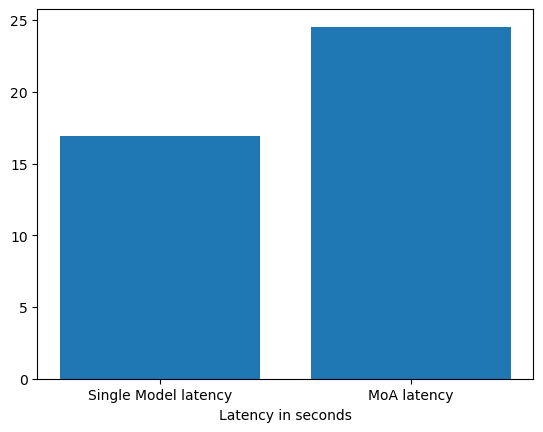

<IPython.core.display.Javascript object>

In [79]:
fig, ax = plt.subplots()
ax.bar(
    [1, 2],
    [
        sum(sonnet_latency) / len(sonnet_latency),
        sum(evaluation_output[:200].total_time) / len(evaluation_output[:200]),
    ],
    tick_label=["Single Model latency", "MoA latency"],
    align="center",
)
ax.set_xlabel("Latency in seconds")
plt.show()